# Hyperparameters optimisation
## TD 7b

We are essentially going to use the same `Food101` ([credit where it's due](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)) data, the same object `ImageDataset`, the same `DataLoader`.

The code below is mainly a copy of the code from the previous TD, except that global variables are now defined separately and everything is wrapped in different functions. This is to make it easier to train the same model with different hyperparameters and architectures, etc ...

For those that can use their GPUs or are on DCEJS, all the necessary `.to(device)` are already in the code.

If, for some reason, you encounter this error: `OutOfMemoryError: CUDA out of memory.`, it means that your GPU does not have enough memory to run the model. You can try to reduce the batch size, or the number of neurons in the network, or the number of layers in the network, or the number of filters in the convolutional layers, etc ...

In [1]:
# Imports

from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pathlib
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set the random seed for reproducibility
_ = torch.manual_seed(25)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You can set the `flush` parameter to `True` for all `print()` statements in `Python` by overriding the built-in `print()` function using the `functools.partial()` method. An example of this is:

```py
from functools import partial
print = partial(print, flush=True)
```

We will use this to make sure that the outputs are printed in the correct order and at the correct time (for more info about why we are doing this, check [this link](https://www.includehelp.com/python/flush-parameter-in-python-with-print-function.aspx)).

In [2]:
from functools import partial
print = partial(print, flush=True)

In [3]:
# Global variables

# Setup device-agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

# Batch size
BATCH_SIZE = 512

# Learning rate
LEARNING_RATE = 2e-2

# Number of epochs
NUM_EPOCHS = 20

# Number of classes
NUM_CLASSES = 3

# Image size
IMAGE_SIZE = 128

Using cuda device


In [4]:
def get_datasets_and_dataloaders(
    batch_size: int = 4
) -> tuple[
    DataLoader, 
    DataLoader
]:
    """
    Load the training and test datasets into data loaders.
    """
    data_dir = pathlib.Path(".")
    train_dir = data_dir / "Food-3-big" / "train"
    test_dir = data_dir / "Food-3-big" / "test"

    data_transform_train = transforms.Compose(
        [
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),  # Resize the images to 128x128
            transforms.ToTensor(),  # Convert the images to tensors
            transforms.RandomHorizontalFlip(p=0.5),  # Flip the images horizontally with probability 0.5
        ]
    )
    data_transform_test = transforms.Compose(
        [
            transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),  # Resize the images to 128x128
            transforms.ToTensor(),  # Convert the images to tensors
        ]
    )

    train_data = datasets.ImageFolder(
        root=train_dir,  # target folder of images
        transform=data_transform_train,  # transforms to perform on data (images)
        target_transform=None  # transforms to perform on labels (if necessary)
    ) 

    test_data = datasets.ImageFolder(
        root=test_dir,
        transform=data_transform_test
    )

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,  # how many samples per batch?
        shuffle=True  # shuffle the data?
    )

    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False
    ) # don't usually need to shuffle testing data


    return train_dataloader, test_dataloader

In [5]:
# Load dataloaders in global variables
TRAIN_DATALOADER, TEST_DATALOADER = get_datasets_and_dataloaders(BATCH_SIZE)

In [6]:
# How can we get the datasets? Did we lose them? No
print(TRAIN_DATALOADER.dataset)
print("---")
print(TEST_DATALOADER.dataset)

Dataset ImageFolder
    Number of datapoints: 3212
    Root location: Food-3-big/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               RandomHorizontalFlip(p=0.5)
           )
---
Dataset ImageFolder
    Number of datapoints: 447
    Root location: Food-3-big/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [7]:
import torch.nn.functional as F

example_tensor = torch.tensor([[1, 2, 3, 4],
                               [5, 6, 7, 8],
                               [9, 10, 11, 12],
                               [13, 14, 15, 16]], dtype=torch.float32)

# First let's go to our configuration: tensor of shape (batch_size, channels, height, width)
example_tensor = example_tensor.unsqueeze(0).unsqueeze(0)  # We add the ones: (1, 1, 4, 4)

# Applying max_pool2d with a 2x2 kernel
pooled_tensor = F.max_pool2d(example_tensor, kernel_size=2)

# Reshaping back to a simple 2D tensor for easy visualization
pooled_tensor = pooled_tensor.squeeze()  # We remove the ones (2, 2)

pooled_tensor

tensor([[ 6.,  8.],
        [14., 16.]])

In [8]:
class Net(nn.Module):
    def __init__(
        self,
        hidden_units: int = 200,
        batch_norm: bool = False,
        use_conv: bool = False
    ):
        super(Net, self).__init__()
        self.use_conv = use_conv
        self.batch_norm = batch_norm

        if use_conv:
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

            if batch_norm:
                self.bn1 = nn.BatchNorm2d(16)
                self.bn2 = nn.BatchNorm2d(32)

            conv_output_size = IMAGE_SIZE // 4  # we will add two poolings of size (2, 2)

            self.fc1 = nn.Linear(32 * conv_output_size * conv_output_size, hidden_units)
        else:
            self.fc1 = nn.Linear(IMAGE_SIZE * IMAGE_SIZE * 3, hidden_units)
            self.bn1 = nn.BatchNorm1d(hidden_units)

        # Shared layers
        self.fc2 = nn.Linear(hidden_units, NUM_CLASSES)

    def forward(self, x):
        if self.use_conv:
            x = self.conv1(x)
            if self.batch_norm:
                x = self.bn1(x)
            x = nn.ReLU()(x)
            x = F.max_pool2d(x, 2)

            x = self.conv2(x)
            if self.batch_norm:
                x = self.bn2(x)
            x = nn.ReLU()(x)
            x = F.max_pool2d(x, 2)

            # Flatten the features for the fully connected layer
            x = x.view(x.size(0), -1)

            x = self.fc1(x)
            x = nn.ReLU()(x)

        else:
            # Flatten in the beginning for the fully connected layer
            x = x.view(x.size(0), -1)
            x = self.fc1(x)
            if self.batch_norm:
                x = self.bn1(x)
            x = nn.ReLU()(x)

        x = self.fc2(x)
        return x

---

Why does it not work with `x = x.view(BATCH_SIZE, -1)`?

---

In [9]:
# Create model
MODEL: Net = Net(hidden_units=200).to(DEVICE)

In [10]:
def test_our_model() -> float:
    # 0. Put model in eval mode
    MODEL.eval()  # to remove stuff like dropout that's only going to be in the training part

    # 1. Setup test accuracy value
    test_acc: float = 0

    # 2. Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in TEST_DATALOADER:  # majuscule à X car c'est une "matrice", et y un entier
            # a. Move data to device and no need to reshape since it's done in MODEL definition
            X_test_flattened = X_test.to(DEVICE) 
            y_test = y_test.to(DEVICE)

            # b. Forward pass
            model_output = MODEL(X_test_flattened)

            # c. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax(dim=1)
            test_acc += (test_pred_label == y_test).sum()

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = test_acc / (len(TEST_DATALOADER.dataset))
    return test_acc.item()

In [11]:
# Test our untrained model
print((f"{100*test_our_model():.2f}%"))

30.20%


You should get 30.20% accuracy on the testing set without training and with the default hyperparameters if you used the same seed. Close enough to 33% which is the expected accuracy for a random classifier.

We can plot some images like last time

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


Text(0.5, 1.0, 'pizza')

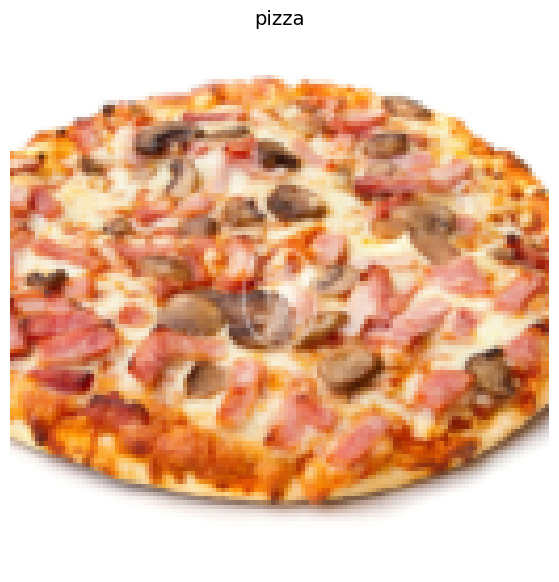

In [11]:
# Get the tensors and put them in the right dimensions for matplotlib
my_pizza = TRAIN_DATALOADER.dataset[0][0]
my_label = TRAIN_DATALOADER.dataset[0][1]
print(my_pizza.shape)
my_pizza_reshaped = my_pizza.permute(1, 2, 0)
print(my_pizza_reshaped.shape)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(my_pizza_reshaped)
plt.axis("off")
plt.title(TRAIN_DATALOADER.dataset.classes[my_label], fontsize=14)

Let's do the training loop now

In [12]:
def main_train(loss_fn, optimizer) -> None:
    """
    Train the model and modified the trained model inplace.
    """
    start_time_global = time.time()

    # Put model in train mode
    MODEL.train()

    # Loop through data loader data batches
    for epoch in range(NUM_EPOCHS):
        start_time_epoch = time.time()

        # Setup train loss and train accuracy values
        train_loss, train_acc = 0, 0

        for X, y in TRAIN_DATALOADER:
            # 0. Move data to device
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            # 1. Forward pass
            y_pred = MODEL(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax(dim=1)
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (len(TRAIN_DATALOADER.dataset))
        train_acc = train_acc / (len(TRAIN_DATALOADER.dataset))
        print(
            f"epoch {epoch+1}/{NUM_EPOCHS},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%,"
            f" time spent during this epoch = {time.time() - start_time_epoch:.2f}s,"
            f" total time spent = {time.time() - start_time_global:.2f}s"
        )

In [14]:
main_train(nn.CrossEntropyLoss(), torch.optim.SGD(MODEL.parameters(), lr=LEARNING_RATE))

/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch 1/20, train_loss = 2.56e-03, train_acc = 34.28%, time spent during this epoch = 35.87s, total time spent = 35.87s
epoch 2/20, train_loss = 2.33e-03, train_acc = 43.03%, time spent during this epoch = 17.55s, total time spent = 53.41s
epoch 3/20, train_loss = 2.29e-03, train_acc = 47.35%, time spent during this epoch = 16.46s, total time spent = 69.88s
epoch 4/20, train_loss = 2.23e-03, train_acc = 49.10%, time spent during this epoch = 15.56s, total time spent = 85.44s
epoch 5/20, train_loss = 2.16e-03, train_acc = 51.46%, time spent during this epoch = 16.06s, total time spent = 101.50s
epoch 6/20, train_loss = 2.12e-03, train_acc = 53.64%, time spent during this epoch = 15.31s, total time spent = 116.81s
epoch 7/20, train_loss = 2.06e-03, train_acc = 54.36%, time spent during this epoch = 15.68s, total time spent = 132.49s
epoch 8/20, train_loss = 2.09e-03, train_acc = 53.92%, time spent during this epoch = 15.47s, total time spent = 147.96s
epoch 9/20, train_loss = 2.14e-03, t

In [15]:
print((f"{100*test_our_model():.2f}%"))

45.19%


You should get 45.19% accuracy on the testing set without training and with the default hyperparameters if you used the same seed. And we definitely reached convergence (the loss is not decreasing that much anymore since epoch 10, and if you try to train for less epochs, you will see that the testing set accuracy will probably increase). Note that by trying that we kind of cheat by using the testing set to infer an information about the number of epochs, we should instead use validation sets and cross validation techniques ... and we will (today)! No worries.

-----

Is it possible for `train_loss` to decrease whilst `train_acc` decreases at the same time? Look at what happens between epochs 14 and 15 in this example (it's a real run, different seed though):
```py
epoch 14/15, train_loss = 1.01e-01, train_acc = 63.61%, time spent ...
epoch 15/15, train_loss = 9.91e-02, train_acc = 63.50%, time spent ...
```

Why is that?

-----

## Let's try to improve this accuracy!

You will need to install the Optuna package (`pip install optuna`) and import it at the beginning of your script. We should also import KFold from sklearn.model_selection. This is because we will use cross-validation to find the best hyperparameters.

In [16]:
%pip install optuna
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import optuna
from sklearn.model_selection import KFold

First easy task is to decide how many neurons there should be in the hidden layer.
 
We will do this together (optimising the number of hidden nuerons), and then you'll have to implement optimization of the learning rate*, the optimizer's choice on your own. We will also show you how to choose between a convolutional and dense network.

\* *Careful! Small learning rates are not always better, especially if you do not change the number of epochs. You should try to find the best learning rate for the number of epochs you chose, one that is not too big for your computer to handle.*

We will need to define a new function that will be used as the objective function for Optuna's optimization. This function should take in the `trial` object from Optuna as an argument and use the `trial` object to define and sample the hyperparameters that you want to optimize. For example, you can use the `trial` object to sample a choice between a convolutional and dense network, and to sample the number of neurons for the chosen network. After training the model, we will need to return the final validation accuracy calculated with cross-validation* as the objective function value for Optuna to maximise.

\* We use cross-validation here (3-fold) because we want to use the testing set as little as possible. We will use the testing set only once, at the end, to get the final accuracy of the best model. But, cross-validation greatly increases the time required to run the algorithms, so we won't always use cross-validation to optimize hyperparameters.

In [14]:
def objective(trial: optuna.trial.Trial) -> float:
    print("New trial")

    # Set up cross validation
    n_splits: int = 3
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = [0]*n_splits

    hidden_units: int = trial.suggest_int('hidden_units', 2, 50)

    # Loop through data loader data batches
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(TRAIN_DATALOADER.dataset)))):
        # train_idx and valid_idx are numpy arrays of indices of the training and validation sets for this 
        # fold respectively.
        # They do not contain the actual data, but the indices of the data in the dataset.
        # We can use these indices to create a subset of the dataset for this fold with torch.utils.data.Subset.
        # Obviously, if an index is in the validation set, it will not be in the training set. You could
        # check this by printing train_idx and valid_idx and check by yourself.
        
        print(f"Fold {fold_idx+1}/{n_splits}")

        # Create subsets of the dataset for this fold
        sub_train_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, train_idx)
        sub_valid_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, valid_idx)

        # Create data loaders for this fold
        sub_train_loader = torch.utils.data.DataLoader(sub_train_data, batch_size=BATCH_SIZE, shuffle=True)
        sub_valid_loader = torch.utils.data.DataLoader(sub_valid_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Generate the model.
        my_model: Net = Net(hidden_units=hidden_units).to(DEVICE)
        
        for epoch in range(NUM_EPOCHS):
            # Training of the model.
            # Put model in train mode
            my_model.train()

            # Set up optimizer
            optimizer = torch.optim.SGD(my_model.parameters(), lr=LEARNING_RATE)

            # Set up loss function
            loss_fn = nn.CrossEntropyLoss()
            for X, y in sub_train_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)

                # 3. Calculate and accumulate loss
                loss = loss_fn(y_pred, y)

                # 4. Optimizer zero grad
                optimizer.zero_grad()

                # 5. Loss backward
                loss.backward()

                # 6. Optimizer step
                optimizer.step()

        # Validation of the model.
        # Put model in eval mode
        my_model.eval()
        
        val_acc = 0
        with torch.no_grad():
            for X, y in sub_valid_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)
                
                # 3. Compute accuracy
                y_pred_class = y_pred.argmax(dim=1)

                val_acc += (y_pred_class == y).sum()

        scores[fold_idx] = (val_acc / len(sub_valid_data)).cpu()
        # bring it back otherwise, np.mean will not work
        print(f"Fold {fold_idx+1}/{n_splits} accuracy: {scores[fold_idx]}")
    
    return np.mean(scores)

Finally, we will need to call the `optuna.create_study()` function to create a new study, and use the `study.optimize()` function to run the optimization, passing the objective function that we defined earlier.

You can find more information about how to use Optuna in the [Optuna documentation](https://optuna.readthedocs.io/en/stable/index.html).

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=1200, n_trials=5) 
# - timeout = 1200 -> stops after 20 minutes;
# - n_trials = 5 -> tries 5 different values for the hyperparameter.

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n")
print("--------------------")
print("--------------------")
print("--------------------")
print("\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key}: {value}")

[I 2024-01-25 09:22:31,569] A new study created in memory with name: no-name-d22497c8-c05f-49c8-9ea0-63126f22f926


New trial
Fold 1/3


/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Fold 1/3 accuracy: 0.521942138671875
Fold 2/3
Fold 2/3 accuracy: 0.5434173941612244
Fold 3/3
Fold 3/3 accuracy: 0.5233644843101501


[I 2024-01-25 09:33:08,780] Trial 0 finished with value: 0.5295746922492981 and parameters: {'hidden_units': 47}. Best is trial 0 with value: 0.5295746922492981.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.5303454995155334
Fold 2/3
Fold 2/3 accuracy: 0.3352007567882538
Fold 3/3
Fold 3/3 accuracy: 0.5037383437156677


[I 2024-01-25 09:43:51,715] Trial 1 finished with value: 0.456428200006485 and parameters: {'hidden_units': 23}. Best is trial 0 with value: 0.5295746922492981.




--------------------
--------------------
--------------------


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
  Value:  0.5295746922492981
  Params: 
	hidden_units: 47


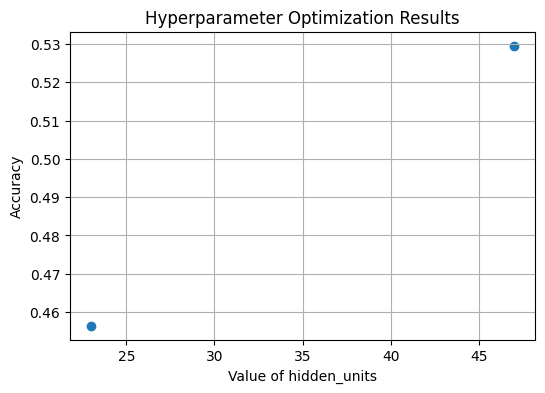

In [20]:
import matplotlib.pyplot as plt

hyperparam_values = [t.params['hidden_units'] for t in complete_trials]
accuracies = [t.value for t in complete_trials]

plt.figure(figsize=(6, 4))
plt.scatter(hyperparam_values, accuracies)
plt.title('Hyperparameter Optimization Results')
plt.xlabel('Value of hidden_units')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

More neurons on the hidden layers is better (when considering the range 5-50). It makes sense!

Few of you might have a problem: we've only allowed 5 trials but `Optuna` tried twice the same trial (unlikely if you set a big range but likely if you only allowed the range [5; 8] for example. An example: https://i.imgur.com/DceMhuf.png). This is because `Optuna` doesn't check if it already has used the previous set of hyperparameters. To fix this, we can add the following code:

```py
from optuna.trial import TrialState

def objective(trial: optuna.trial.Trial) -> float:
    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            print(f"Duplicated trial: {trial.params}, return {previous_trial.value}")
            return previous_trial.value
    ...
...
```

And even setting n_trials to 5000, we won't have optuna running two "experiments" with the same hyperparameters.

Let's add this and let's also optimize on the learning rate, the number of epochs, the use of batch normalisation layers, and the optimizer's choice.

We also add some manual pruning.

In [15]:
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

def objective(trial: optuna.trial.Trial) -> float:
    print("New trial")

    for previous_trial in trial.study.trials:
        if previous_trial.state == TrialState.COMPLETE and trial.params == previous_trial.params:
            print(f"Duplicated trial: {trial.params}, return {previous_trial.value}")
            return previous_trial.value
        
    # Set up cross validation
    n_splits: int = 3
    fold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    scores = [0]*n_splits

    # Manual pruning
    try:
        best_score = trial.study.best_value
    except ValueError:
        best_score = 0

    # Hyperparameters choice
    hidden_units: int = trial.suggest_int('hidden_units', 2, 1000)
    learning_rate: float = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimiser: str = trial.suggest_categorical('optimiser', ['SGD', 'Adam'])
    num_epochs: int = trial.suggest_int('epochs', 5, 20)
    batch_norm: bool = trial.suggest_categorical('batch_norm', [True, False])
    use_conv: bool = trial.suggest_categorical('use_conv', [True, False])

    # Loop through data loader data batches
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(TRAIN_DATALOADER.dataset)))):
        # train_idx and valid_idx are numpy arrays of indices of the training and validation sets for this 
        # fold respectively.
        # They do not contain the actual data, but the indices of the data in the dataset.
        # We can use these indices to create a subset of the dataset for this fold with torch.utils.data.Subset.
        # Obviously, if an index is in the validation set, it will not be in the training set. You could
        # check this by printing train_idx and valid_idx and check by yourself.
        
        print(f"Fold {fold_idx+1}/{n_splits}")

        # Create subsets of the dataset for this fold
        sub_train_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, train_idx)
        sub_valid_data = torch.utils.data.Subset(TRAIN_DATALOADER.dataset, valid_idx)

        # Create data loaders for this fold
        sub_train_loader = torch.utils.data.DataLoader(sub_train_data, batch_size=BATCH_SIZE, shuffle=True)
        sub_valid_loader = torch.utils.data.DataLoader(sub_valid_data, batch_size=BATCH_SIZE, shuffle=False)
        
        # Generate the model.
        my_model: Net = Net(
            hidden_units=hidden_units,
            batch_norm=batch_norm,
            use_conv=use_conv
        ).to(DEVICE)
        
        for epoch in range(num_epochs):
            # Training of the model.
            # Put model in train mode
            my_model.train()

            # Set up optimizer
            if optimiser == 'SGD':
                optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate)
            elif optimiser == 'Adam':
                optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
            else:
                raise ValueError(f"Unknown optimiser {optimiser}")

            # Set up loss function
            loss_fn = nn.CrossEntropyLoss()
            for X, y in sub_train_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)

                # 3. Calculate and accumulate loss
                loss = loss_fn(y_pred, y)

                # 4. Optimizer zero grad
                optimizer.zero_grad()

                # 5. Loss backward
                loss.backward()

                # 6. Optimizer step
                optimizer.step()

        # Validation of the model.
        # Put model in eval mode
        my_model.eval()
        
        val_acc = 0
        with torch.no_grad():
            for X, y in sub_valid_loader:
                # 1. Move data to device
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                # 2. Forward pass
                y_pred = my_model(X)
                
                # 3. Compute accuracy
                y_pred_class = y_pred.argmax(dim=1)

                val_acc += (y_pred_class == y).sum()

        scores[fold_idx] = (val_acc / len(sub_valid_data)).cpu()
        # bring it back otherwise, np.mean will not work
        print(f"Fold {fold_idx+1}/{n_splits} accuracy: {scores[fold_idx]}")

        if fold_idx != 3 and np.mean(scores[:fold_idx+1]) < best_score * 0.8:
            print("Pruning trial")
            raise TrialPruned()
    
    return np.mean(scores)

In [22]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=3600, n_trials=20) 
# - timeout = 3600 -> stops after 60 minutes;
# - n_trials = 20 -> tries 20 different values for the hyperparameter.

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n")
print("--------------------")
print("--------------------")
print("--------------------")
print("\n")
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key}: {value}")

[I 2024-01-25 09:43:51,858] A new study created in memory with name: no-name-2345ea2b-c923-4efe-baa9-15f0e0e7e65f


New trial
Fold 1/3


Fold 1/3 accuracy: 0.5676937699317932
Fold 2/3
Fold 2/3 accuracy: 0.5611578226089478
Fold 3/3
Fold 3/3 accuracy: 0.590654194355011


[I 2024-01-25 09:48:50,712] Trial 0 finished with value: 0.5731685757637024 and parameters: {'hidden_units': 607, 'learning_rate': 0.001249646236957724, 'optimiser': 'SGD', 'epochs': 9, 'batch_norm': False, 'use_conv': False}. Best is trial 0 with value: 0.5731685757637024.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.5695611834526062
Fold 2/3
Fold 2/3 accuracy: 0.5452848076820374
Fold 3/3
Fold 3/3 accuracy: 0.5915887951850891


[I 2024-01-25 09:56:21,764] Trial 1 finished with value: 0.5688115954399109 and parameters: {'hidden_units': 628, 'learning_rate': 0.0005829877495750517, 'optimiser': 'SGD', 'epochs': 14, 'batch_norm': False, 'use_conv': False}. Best is trial 0 with value: 0.5731685757637024.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.3520074784755707
Pruning trial


[I 2024-01-25 09:57:56,583] Trial 2 pruned. 


New trial
Fold 1/3
Fold 1/3 accuracy: 0.48179271817207336
Fold 2/3
Fold 2/3 accuracy: 0.42296919226646423
Pruning trial


[I 2024-01-25 10:01:13,241] Trial 3 pruned. 


New trial
Fold 1/3
Fold 1/3 accuracy: 0.5985060930252075
Fold 2/3
Fold 2/3 accuracy: 0.6265172958374023
Fold 3/3
Fold 3/3 accuracy: 0.6700934767723083


[I 2024-01-25 10:10:21,339] Trial 4 finished with value: 0.6317055821418762 and parameters: {'hidden_units': 216, 'learning_rate': 0.00019579706899839637, 'optimiser': 'Adam', 'epochs': 17, 'batch_norm': True, 'use_conv': True}. Best is trial 4 with value: 0.6317055821418762.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.49953314661979675
Pruning trial


[I 2024-01-25 10:13:36,052] Trial 5 pruned. 


New trial
Fold 1/3
Fold 1/3 accuracy: 0.5508870482444763
Fold 2/3
Fold 2/3 accuracy: 0.5228758454322815
Fold 3/3
Fold 3/3 accuracy: 0.5943925380706787


[I 2024-01-25 10:20:08,000] Trial 6 finished with value: 0.5560517907142639 and parameters: {'hidden_units': 611, 'learning_rate': 0.00010476366903794542, 'optimiser': 'SGD', 'epochs': 12, 'batch_norm': True, 'use_conv': False}. Best is trial 4 with value: 0.6317055821418762.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.6470588445663452
Fold 2/3
Fold 2/3 accuracy: 0.5340803265571594
Fold 3/3
Fold 3/3 accuracy: 0.5149533152580261


[I 2024-01-25 10:27:48,967] Trial 7 finished with value: 0.5653641819953918 and parameters: {'hidden_units': 529, 'learning_rate': 0.00035511024244516974, 'optimiser': 'Adam', 'epochs': 14, 'batch_norm': True, 'use_conv': True}. Best is trial 4 with value: 0.6317055821418762.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.5396825671195984
Fold 2/3
Fold 2/3 accuracy: 0.525676965713501
Fold 3/3
Fold 3/3 accuracy: 0.5308411121368408


[I 2024-01-25 10:32:49,553] Trial 8 finished with value: 0.5320668816566467 and parameters: {'hidden_units': 910, 'learning_rate': 0.0019960372685242094, 'optimiser': 'SGD', 'epochs': 9, 'batch_norm': True, 'use_conv': False}. Best is trial 4 with value: 0.6317055821418762.


New trial
Fold 1/3
Fold 1/3 accuracy: 0.5228758454322815
Fold 2/3
Fold 2/3 accuracy: 0.5023342967033386
Fold 3/3
Fold 3/3 accuracy: 0.45140188932418823
Pruning trial


[I 2024-01-25 10:36:45,946] Trial 9 pruned. 


New trial
Fold 1/3
Fold 1/3 accuracy: 0.32492998242378235
Pruning trial


[I 2024-01-25 10:40:15,041] Trial 10 pruned. 


New trial
Fold 1/3
Fold 1/3 accuracy: 0.6153128147125244
Fold 2/3
Fold 2/3 accuracy: 0.5490196347236633
Fold 3/3
Fold 3/3 accuracy: 0.6000000238418579


[I 2024-01-25 10:49:59,413] Trial 11 finished with value: 0.5881108045578003 and parameters: {'hidden_units': 312, 'learning_rate': 6.285344769773051e-05, 'optimiser': 'Adam', 'epochs': 18, 'batch_norm': False, 'use_conv': True}. Best is trial 4 with value: 0.6317055821418762.




--------------------
--------------------
--------------------


Study statistics: 
  Number of finished trials:  12
  Number of pruned trials:  5
  Number of complete trials:  7
Best trial:
  Value:  0.6317055821418762
  Params: 
	hidden_units: 216
	learning_rate: 0.00019579706899839637
	optimiser: Adam
	epochs: 17
	batch_norm: True
	use_conv: True


Let's now train the whole model with the optimal hyperparameters that we found with Optuna. We will use the `study.best_params` attribute to get the best hyperparameters. You need to re-train on the whole training dataset!!! Otherwise, you will not get the best accuracy as you're leaving out some data.

In [ ]:
study.best_params  # display the best hyperparameters

In [16]:
# Create model
MODEL: Net = Net(hidden_units=216, batch_norm = True, use_conv = True).to(DEVICE)

# Set number of epochs
NUM_EPOCHS = 17

In [17]:
print(MODEL)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=216, bias=True)
  (fc2): Linear(in_features=216, out_features=3, bias=True)
)


In [18]:
main_train(nn.CrossEntropyLoss(), torch.optim.Adam(MODEL.parameters(), lr=0.00019579706899839637))

/usr/lib/python3/dist-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch 1/17, train_loss = 4.50e-03, train_acc = 41.28%, time spent during this epoch = 42.06s, total time spent = 42.06s
epoch 2/17, train_loss = 2.09e-03, train_acc = 51.68%, time spent during this epoch = 18.66s, total time spent = 60.73s
epoch 3/17, train_loss = 1.88e-03, train_acc = 58.19%, time spent during this epoch = 17.53s, total time spent = 78.26s
epoch 4/17, train_loss = 1.82e-03, train_acc = 63.08%, time spent during this epoch = 17.02s, total time spent = 95.28s
epoch 5/17, train_loss = 1.75e-03, train_acc = 63.76%, time spent during this epoch = 17.17s, total time spent = 112.45s
epoch 6/17, train_loss = 1.71e-03, train_acc = 64.79%, time spent during this epoch = 17.27s, total time spent = 129.72s
epoch 7/17, train_loss = 1.67e-03, train_acc = 65.60%, time spent during this epoch = 17.00s, total time spent = 146.71s
epoch 8/17, train_loss = 1.61e-03, train_acc = 66.78%, time spent during this epoch = 17.10s, total time spent = 163.82s
epoch 9/17, train_loss = 1.58e-03, t

In [19]:
test_our_model()

0.6935123205184937

Fewer trials for hyperparameter optimisation (more data, same time allocated for both notebooks), but ended up at 69.4% of accuracy against 61.2% on the other notebook which had less data. Goes to show the "power" of data.